This notebook is trained on Local PC

In [ ]:
#MobileNetV3(BackBone) + UNet for image segmentation to detect rotten part of the fruits

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential, load_model
from tensorflow import keras
from keras import Model
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.applications import MobileNetV3Small
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
import random
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
import albumentations as A

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Data Preprocessing and Generation

In [28]:
#Generate 0-255 Mask
import json
import numpy as np
import cv2
import glob
from pathlib import Path

# read json file
images_path = glob.glob("C:/Users/wwwlo/labelme/examples/instance_segmentation/train/rottenTo2/*.png")
masks_path = glob.glob("C:/Users/wwwlo/labelme/examples/instance_segmentation/train/rottenTo2/*.json")
loc = "C:/Users/wwwlo/labelme/examples/instance_segmentation/train/binary_mask"
for i in range(len(images_path)):
    name = Path(images_path[i]).stem
    
    with open(masks_path[i], "r") as f:
        data = json.load(f)

    shapes = data["shapes"]

    image = cv2.imread(images_path[i])

    mask = np.zeros_like(image, dtype=np.uint8)
    
    for shape in shapes:
        points = shape["points"]
        points = np.array(points, dtype=np.int32)
        cv2.fillPoly(mask, [points], (255, 255, 255))
    
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(mask_gray, 1, 255, cv2.THRESH_BINARY)
    
    new_mask_path = f"{loc}/{name}.png"
    cv2.imwrite(new_mask_path, mask)

In [ ]:
#Generate more picture (Augmentation)
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
import random
import os
import albumentations as A
images_to_generate=1000

#Semantic
images_path="C:/Users/wwwlo/labelme/examples/instance_segmentation/train_voc/JPEGImages/" #path to original images
masks_path = "C:/Users/wwwlo/labelme/examples/instance_segmentation/train_voc/SegmentationClass/"
#Instance
images_path="C:/Users/wwwlo/labelme/examples/instance_segmentation/train_voc/JPEGImages/" #path to original images
masks_path = "C:/Users/wwwlo/labelme/examples/instance_segmentation/train/binary_mask/"
img_augmented_path="C:/Users/wwwlo/labelme/examples/instance_segmentation/aug_img/" # path to store aumented images
msk_augmented_path="C:/Users/wwwlo/labelme/examples/instance_segmentation/aug_mask/" # path to store aumented images

images=[]
masks=[]

for im in os.listdir(images_path):   
    images.append(os.path.join(images_path,im))
for msk in os.listdir(masks_path):  
    masks.append(os.path.join(masks_path,msk))

aug = A.Compose([
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=1),
    A.Transpose(p=1),
    ]
)
random.seed(42)
for i in range(1,images_to_generate+1): 
    number = random.randint(0, len(images)-1)
    image = images[number]
    mask = masks[number]
    print(image, mask)
    original_image = io.imread(image)
    original_mask = io.imread(mask)
    
    augmented = aug(image=original_image, mask=original_mask)
    transformed_image = augmented['image']
    transformed_mask = augmented['mask']

        
    new_image_path= "%s/augmented_image_%s.png" %(img_augmented_path, i)
    new_mask_path = "%s/augmented_mask_%s.png" %(msk_augmented_path, i)
    io.imsave(new_image_path, transformed_image)
    io.imsave(new_mask_path, transformed_mask)

In [ ]:
#LabelMe not support JPG to VOC
from PIL import Image
from pathlib import Path
import os
import glob
path = "C:/Users/wwwlo/labelme/examples/instance_segmentation/train/toPNG/"
images=[] 
for im in os.listdir(path):   
    images.append(os.path.join(path,im))

for i in range(len(images)):
    name = Path(images[i]).stem 
    im = Image.open(images[i])
    im = im.convert('RGB')
    im.save('%s.png'%(path+name))


Data Loading

In [2]:
def data_loader(folder_dir):
    image_dataset = []
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset
#image path, mask path
path1="C:/Users/wwwlo/labelme/examples/instance_segmentation/aug_img/" 
path2="C:/Users/wwwlo/labelme/examples/instance_segmentation/aug_mask/"
image_dataset = data_loader(path1)
mask_dataset  = data_loader(path2)
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
print(image_dataset.shape)
print(mask_dataset.shape)
#(len, 224,224 ,3)

(1000, 224, 224, 3)
(1000, 224, 224, 3)


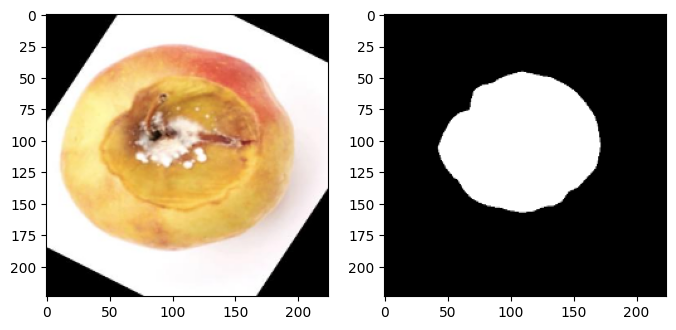

In [3]:
#Sanity check
def display_check(first_check = True):
    image_number = random.randint(0, len(image_dataset))
    plt.figure(figsize=(8, 6))
    plt.subplot(121)
    plt.imshow(image_dataset[image_number])
    plt.subplot(122)
    plt.imshow(mask_dataset[image_number])
    if(first_check):
        cv2.cvtColor(mask_dataset[image_number], cv2.COLOR_BGR2GRAY)
    plt.show()



#Rotten (128,0,0)
#Fruit (0,128,0)
#Bg (0,0,0)

display_check()

In [4]:
class_idx = {
    0: [(128,0,0), 'rotten'],
    1: [(0,0,0), 'background']
}

In [5]:
num_of_pic = mask_dataset.shape[0]
num_of_label = len(class_idx)
def rgb_to_labels(img):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(num_of_label):
        #print(list(class_idx[0][0]))
        label_seg[np.all(img == list(class_idx[i][0]), axis=-1)] = i
    #print(label_seg.shape) # 3 channel
    label_seg = label_seg[:,:,0]
    #print(label_seg.shape) # 1 channel now
    return label_seg
labels = []
for i in range(num_of_pic):
    label = rgb_to_labels(mask_dataset[i]) 
    labels.append(label)

In [6]:
labels = np.array(labels)
#print(labels.shape)
labels = np.expand_dims(labels, axis=3) # add classes
#print(labels.shape)

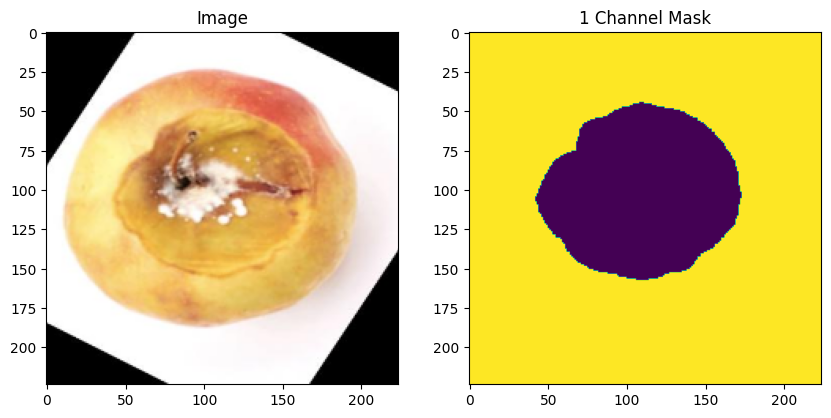

In [7]:
#Purple = rotten, Yellow = background
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.title('Image')
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.title('1 Channel Mask')
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [8]:
labels = to_categorical(labels, num_classes=num_of_label) #encode label to 0,1 (len,224,224,num_classes)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size = 0.2, random_state = 42)


In [9]:
#Unet Structure (Encoder, connection, Decoder)
'''
(224,224)
Input: conv 3x3 Relu -> conv 3x3 Relu -> conv 1x1
ReluX : conv 3x3 Relu -> conv 3x3 Relu -> upSample(previous relu 2x2)
'''
from tensorflow.keras.applications import MobileNetV3Large,MobileNetV3Small
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.GaussianNoise(0.2),
])
def unet_mobilenetv3_large_model():
    inputs = tf.keras.Input(shape=(224, 224, 3),name="input_image")
    #preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
    #x = data_augmentation(inputs)
    #x = preprocess_input(x)
    encoder = MobileNetV3Large(input_tensor=inputs, weights="imagenet", include_top=False)
    #encoder.trainable = False
    #x = encoder(x, training=False)
    layer_name = ["input_image", "re_lu_2", "re_lu_6", "re_lu_15"]
    #Get input,2,6,15 as encoder, build upsample for Unet
    encoder_output = encoder.get_layer("re_lu_29").output
    
    f = [14, 28, 56, 112]
    x = encoder_output
    for i in range(1, len(layer_name)+1, 1):
        e = encoder.get_layer(layer_name[-i]).output
        print(e)
        x = tf.keras.layers.UpSampling2D((2, 2))(x)
        x = tf.keras.layers.Concatenate()([x, e])
        
        x = tf.keras.layers.Conv2D(f[-i], (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        
        x = tf.keras.layers.Conv2D(f[-i], (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        
    x = tf.keras.layers.Conv2D(num_of_label, (1, 1), padding="same")(x)
    #x = tf.keras.layers.Activation("softmax")(x)
    x = tf.keras.layers.Activation("sigmoid")(x)
    
    model = tf.keras.Model(inputs, x)
    return model

In [141]:
#model = unet_mobilenetv3_large_model()
model = tf.keras.models.load_model('Models/MobileNetV3Large-UNet(5e-4)(16).keras')
#Fine tune
for layer in model.layers[:-20]:
    layer.trainable = False
model.compile(
    #loss='categorical_crossentropy',
    loss='binary_crossentropy',
    #optimizer=tf.keras.optimizers.Adam(5e-2),
    #optimizer=tf.keras.optimizers.Adam(5e-3),
    optimizer=tf.keras.optimizers.Adam(5e-5),
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.AUC(
            num_thresholds=200,
            curve='ROC',
            summation_method='interpolation')

    ])

In [131]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_image[0][0]']            
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

Training

In [142]:
history = model.fit(X_train, 
          y_train,
          batch_size=16, 
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/10
50/50 [==============================] - 12s 182ms/step - loss: 0.1088 - accuracy: 0.9860 - recall_18: 0.9857 - precision_18: 0.9862 - auc_18: 0.9974 - val_loss: 0.1122 - val_accuracy: 0.9826 - val_recall_18: 0.9823 - val_precision_18: 0.9827 - val_auc_18: 0.9966
Epoch 2/10
50/50 [==============================] - 7s 146ms/step - loss: 0.1064 - accuracy: 0.9862 - recall_18: 0.9859 - precision_18: 0.9864 - auc_18: 0.9977 - val_loss: 0.1084 - val_accuracy: 0.9829 - val_recall_18: 0.9826 - val_precision_18: 0.9831 - val_auc_18: 0.9968
Epoch 3/10
50/50 [==============================] - 7s 146ms/step - loss: 0.1045 - accuracy: 0.9861 - recall_18: 0.9859 - precision_18: 0.9863 - auc_18: 0.9977 - val_loss: 0.1060 - val_accuracy: 0.9831 - val_recall_18: 0.9827 - val_precision_18: 0.9835 - val_auc_18: 0.9972
Epoch 4/10
50/50 [==============================] - 7s 146ms/step - loss: 0.1031 - accuracy: 0.9861 - recall_18: 0.9859 - precision_18: 0.9863 - auc_18: 0.9977 - val_loss: 0.107

In [114]:
model.save("./Models/MobileNetV3Large-UNet(5e-5)(16)(F-34).keras")

In [179]:
print(history.history)

#Model A History 4 batch
ModelA = {'loss': [0.285003662109375, 0.2159513533115387, 0.19943886995315552, 0.17524553835391998, 0.17334868013858795, 0.16307991743087769, 0.15311338007450104, 0.14581549167633057, 0.14245429635047913, 0.13339769840240479], 'accuracy': [0.8742364645004272, 0.9044250249862671, 0.9166710376739502, 0.9287119507789612, 0.929225504398346, 0.9341192841529846, 0.9397460222244263, 0.9420756101608276, 0.944632887840271, 0.9476550817489624], 'recall': [0.8772594332695007, 0.8960764408111572, 0.9152231812477112, 0.9281493425369263, 0.9287651181221008, 0.933967113494873, 0.9396252036094666, 0.9419387578964233, 0.9445499777793884, 0.9476073980331421], 'precision': [0.8654918670654297, 0.9120122790336609, 0.9178340435028076, 0.929186999797821, 0.9296141266822815, 0.9342517256736755, 0.9398478269577026, 0.9421871900558472, 0.9447067975997925, 0.9476962089538574], 'auc': [0.9502200484275818, 0.9716621041297913, 0.9758561253547668, 0.981242299079895, 0.9815452694892883, 0.9836112260818481, 0.985489547252655, 0.9867869019508362, 0.9872581362724304, 0.9888104200363159], 'val_loss': [416.0096130371094, 101.5503158569336, 10.36395263671875, 4.426231861114502, 2.552095413208008, 4.039494037628174, 1.8044672012329102, 1.9273396730422974, 1.8742762804031372, 2.6629202365875244], 'val_accuracy': [0.8637158274650574, 0.8637158274650574, 0.8629034757614136, 0.863714337348938, 0.8617027997970581, 0.8637158274650574, 0.8046970367431641, 0.8637158274650574, 0.8637158274650574, 0.8637158274650574], 'val_recall': [0.8637158274650574, 0.8637158274650574, 0.8628748655319214, 0.863714337348938, 0.8617948889732361, 0.8637158274650574, 0.8147621154785156, 0.8637158274650574, 0.8637158274650574, 0.8637158274650574], 'val_precision': [0.8637158274650574, 0.8637158274650574, 0.8629191517829895, 0.8637142181396484, 0.8616333603858948, 0.8637158274650574, 0.7949665784835815, 0.8637158274650574, 0.8637158274650574, 0.8637158274650574], 'val_auc': [0.8637158870697021, 0.8637142181396484, 0.8339927196502686, 0.8636599779129028, 0.8217505216598511, 0.8398815989494324, 0.8069593906402588, 0.8627554774284363, 0.8608579039573669, 0.8635450005531311]}
ModelB = {'loss': [0.2181709259748459, 0.0884861871600151, 0.07524514198303223, 0.07391247898340225, 0.052694037556648254, 0.0571807324886322, 0.049410630017519, 0.03954695537686348, 0.04109010100364685, 0.054606448858976364], 'accuracy': [0.9273499250411987, 0.9692339897155762, 0.9720454216003418, 0.9727916717529297, 0.9800695776939392, 0.9783147573471069, 0.9809887409210205, 0.984720766544342, 0.98378586769104, 0.9792277216911316], 'recall': [0.9385342597961426, 0.9691943526268005, 0.9719506502151489, 0.9721987843513489, 0.9799237847328186, 0.9779619574546814, 0.9806099534034729, 0.9845620393753052, 0.9836600422859192, 0.9787680506706238], 'precision': [0.9184675812721252, 0.9692496061325073, 0.972099244594574, 0.9733368754386902, 0.9802010655403137, 0.9786391258239746, 0.9813472032546997, 0.9848591089248657, 0.9838948249816895, 0.9796432256698608], 'auc': [0.9759848713874817, 0.9951844215393066, 0.9964461326599121, 0.9964030385017395, 0.9980891346931458, 0.9977237582206726, 0.9982624053955078, 0.9988536834716797, 0.9987701177597046, 0.9976569414138794], 'val_loss': [1.0457605123519897, 0.5952139496803284, 1.0302292108535767, 1.0746134519577026, 0.9363274574279785, 0.8886748552322388, 0.9038175344467163, 1.1642975807189941, 2.055968999862671, 1.2920925617218018], 'val_accuracy': [0.8601047396659851, 0.8478911519050598, 0.785696268081665, 0.8529061675071716, 0.8009562492370605, 0.8258588910102844, 0.8469391465187073, 0.8603604435920715, 0.8622058629989624, 0.8606685400009155], 'val_recall': [0.8601794838905334, 0.8478685021400452, 0.7830353379249573, 0.8527393341064453, 0.8014407157897949, 0.8252313137054443, 0.846512496471405, 0.8603678345680237, 0.8623906970024109, 0.8607321381568909], 'val_precision': [0.8600414991378784, 0.8478488326072693, 0.7872499823570251, 0.8530035614967346, 0.8006436824798584, 0.8262476921081543, 0.8471916317939758, 0.8603424429893494, 0.8620632886886597, 0.8606378436088562], 'val_auc': [0.857355535030365, 0.8989257216453552, 0.8456761837005615, 0.874784529209137, 0.8479336500167847, 0.876440703868866, 0.8742746710777283, 0.871489405632019, 0.8666115403175354, 0.870256781578064]}
ModelC = {'loss': [0.4757319688796997, 0.2591606378555298, 0.18215323984622955, 0.1324997991323471, 0.0999300479888916, 0.07604417949914932, 0.06321723759174347, 0.052186351269483566, 0.04258427768945694, 0.03805570676922798], 'accuracy': [0.8453526496887207, 0.9747554659843445, 0.980323076248169, 0.9836567044258118, 0.9854257106781006, 0.9878465533256531, 0.9883784055709839, 0.9896548390388489, 0.9910780191421509, 0.9913468360900879], 'recall': [0.7759142518043518, 0.9754588603973389, 0.9814630746841431, 0.9844591021537781, 0.9859875440597534, 0.9881768226623535, 0.9886379837989807, 0.9898490309715271, 0.9912188053131104, 0.9914889335632324], 'precision': [0.8556250929832458, 0.9735845327377319, 0.9790249466896057, 0.9827641248703003, 0.9847986102104187, 0.9874507188796997, 0.9880765676498413, 0.9894297122955322, 0.9909083843231201, 0.9911766648292542], 'auc': [0.9123598337173462, 0.9886349439620972, 0.9938687682151794, 0.9964417815208435, 0.9977676272392273, 0.998735785484314, 0.9988987445831299, 0.999232828617096, 0.9994944930076599, 0.9995607733726501], 'val_loss': [3.6864898204803467, 0.36200574040412903, 0.1948067843914032, 0.1227395087480545, 0.11408311873674393, 0.10815505683422089, 0.06405344605445862, 0.04960530623793602, 0.04793364182114601, 0.04277623072266579], 'val_accuracy': [0.428628534078598, 0.916618287563324, 0.964972198009491, 0.9763301014900208, 0.9722428917884827, 0.9694098830223083, 0.9831399321556091, 0.9866321682929993, 0.9852720499038696, 0.9864498972892761], 'val_recall': [0.3282502591609955, 0.911238431930542, 0.9666470289230347, 0.9773597121238708, 0.9737583994865417, 0.9701506495475769, 0.9836796522140503, 0.9871201515197754, 0.9856163263320923, 0.9865891933441162], 'val_precision': [0.38479235768318176, 0.917892336845398, 0.9630829691886902, 0.9752274751663208, 0.9706780910491943, 0.9686660170555115, 0.9825654029846191, 0.9861246943473816, 0.9849100708961487, 0.9862877726554871], 'val_auc': [0.33759939670562744, 0.9318354725837708, 0.9891136288642883, 0.9954276084899902, 0.9921448826789856, 0.9932149052619934, 0.9980052709579468, 0.9985750913619995, 0.9984931349754333, 0.998903214931488]}

ModelC_freeze = {'loss': [0.45397862792015076, 0.2855333089828491, 0.21382743120193481, 0.16697990894317627, 0.13298901915550232, 0.1049434021115303, 0.08783701062202454, 0.07478242367506027, 0.06460366398096085, 0.05892249569296837], 'accuracy': [0.9028975963592529, 0.9657357931137085, 0.9742398858070374, 0.9764339327812195, 0.979443371295929, 0.9829592108726501, 0.983860433101654, 0.9848668575286865, 0.9858914613723755, 0.9860085248947144], 'recall': [0.8102641105651855, 0.9629217386245728, 0.9730532765388489, 0.9756786823272705, 0.9789023399353027, 0.982677698135376, 0.9835776090621948, 0.9846752285957336, 0.9856627583503723, 0.9858124256134033], 'precision': [0.9326461553573608, 0.9674839973449707, 0.9751819968223572, 0.9770526885986328, 0.9798852801322937, 0.9831817746162415, 0.9840859770774841, 0.9850046634674072, 0.9860666394233704, 0.9861689805984497], 'auc': [0.9420158863067627, 0.9844273924827576, 0.9917168617248535, 0.9939546585083008, 0.9958567023277283, 0.9971375465393066, 0.9976854920387268, 0.9980341792106628, 0.9985364675521851, 0.9985663294792175], 'val_loss': [0.40388479828834534, 0.2830175459384918, 0.20408685505390167, 0.2079816311597824, 0.11390972882509232, 0.1097283586859703, 0.25373610854148865, 0.08400515466928482, 0.9290931224822998, 0.1065792366862297], 'val_accuracy': [0.9512009620666504, 0.9391374588012695, 0.9623674750328064, 0.9575057625770569, 0.9772669076919556, 0.9732117652893066, 0.9196504354476929, 0.9766892790794373, 0.6175443530082703, 0.965700626373291], 'val_recall': [0.8869659900665283, 0.9365962743759155, 0.9609628915786743, 0.9566155076026917, 0.9770660400390625, 0.9727609753608704, 0.9194304943084717, 0.9764803051948547, 0.6044720411300659, 0.9649623036384583], 'val_precision': [0.9517577290534973, 0.9413408637046814, 0.963532567024231, 0.9581347703933716, 0.9774028062820435, 0.9736722707748413, 0.919867753982544, 0.9768680930137634, 0.6191231608390808, 0.9662939310073853], 'val_auc': [0.9580079317092896, 0.9683980941772461, 0.9842769503593445, 0.9766485095024109, 0.9949015378952026, 0.9939531087875366, 0.9516716003417969, 0.9965064525604248, 0.7210540771484375, 0.9920190572738647]}
ModelC_nonfreeze ={'loss': [0.04930372163653374, 0.04581606760621071, 0.042764533311128616, 0.04178013652563095, 0.034965526312589645, 0.032828520983457565, 0.028204502537846565, 0.026240725070238113, 0.02494918182492256, 0.023801656439900398], 'accuracy': [0.9880059957504272, 0.9881903529167175, 0.9883815050125122, 0.9877981543540955, 0.9898801445960999, 0.9901895523071289, 0.9916346669197083, 0.9919273257255554, 0.9921600222587585, 0.9923999309539795], 'recall': [0.9878891110420227, 0.9880657196044922, 0.9882864356040955, 0.9877278804779053, 0.989810049533844, 0.9901508688926697, 0.9916029572486877, 0.9919052720069885, 0.9921336770057678, 0.9923738241195679], 'precision': [0.9881008267402649, 0.9882898330688477, 0.9884562492370605, 0.9878448247909546, 0.9899325966835022, 0.990211546421051, 0.9916556477546692, 0.9919432401657104, 0.9921747446060181, 0.9924147129058838], 'auc': [0.9990343451499939, 0.9990372061729431, 0.9991586804389954, 0.9991485476493835, 0.9994400143623352, 0.999476432800293, 0.9996179938316345, 0.9996762871742249, 0.9997022747993469, 0.9997131824493408], 'val_loss': [0.06470944732427597, 0.06456024199724197, 0.06383141875267029, 0.08618808537721634, 0.041524410247802734, 0.05221892520785332, 0.03806339576840401, 0.047758202999830246, 0.040069885551929474, 0.03633211553096771], 'val_accuracy': [0.9791443943977356, 0.980942964553833, 0.9832044243812561, 0.9743863344192505, 0.9857563376426697, 0.984323263168335, 0.9874417781829834, 0.9827618598937988, 0.9865535497665405, 0.9873273968696594], 'val_recall': [0.9787222743034363, 0.9806108474731445, 0.9828208684921265, 0.9737593531608582, 0.9856932759284973, 0.9842495322227478, 0.987339973449707, 0.9825319647789001, 0.9864163398742676, 0.9872594475746155], 'val_precision': [0.9795131087303162, 0.9812175631523132, 0.98358154296875, 0.9748754501342773, 0.9857990741729736, 0.9843801259994507, 0.9875273108482361, 0.9829438924789429, 0.9866570234298706, 0.987383246421814], 'val_auc': [0.9976061582565308, 0.9974787831306458, 0.9967138767242432, 0.9936121106147766, 0.9989097714424133, 0.9976821541786194, 0.9991244673728943, 0.9987047910690308, 0.9990699291229248, 0.9989967346191406]}
ModelC_16 ={'loss': [0.5447950959205627, 0.4107791781425476, 0.3279256820678711, 0.27264559268951416, 0.2315436601638794, 0.19523505866527557, 0.16680990159511566, 0.14144012331962585, 0.1229369267821312, 0.10631189495325089], 'accuracy': [0.8750157356262207, 0.9713165760040283, 0.9817720651626587, 0.9842725396156311, 0.9855038523674011, 0.9875541925430298, 0.9886903166770935, 0.9903753995895386, 0.9904695749282837, 0.9914746284484863], 'recall': [0.618638277053833, 0.9350618720054626, 0.9751682281494141, 0.9817497134208679, 0.984085738658905, 0.9866458177566528, 0.9880375266075134, 0.9899193644523621, 0.9901331067085266, 0.991182267665863], 'precision': [0.8970032334327698, 0.9754685163497925, 0.9849892258644104, 0.9859092235565186, 0.9865426421165466, 0.988245964050293, 0.9892040491104126, 0.9907338619232178, 0.9907499551773071, 0.9917125105857849], 'auc': [0.9060467481613159, 0.9894173741340637, 0.9957142472267151, 0.9964743256568909, 0.996986985206604, 0.9979221224784851, 0.9983413219451904, 0.9988439083099365, 0.9989528656005859, 0.9992316365242004], 'val_loss': [1.7092050313949585, 0.5184550285339355, 0.4304323196411133, 0.3703432083129883, 0.2861679196357727, 0.23711815476417542, 0.18197926878929138, 0.17010633647441864, 0.13000930845737457, 0.1211637407541275], 'val_accuracy': [0.193991556763649, 0.8643669486045837, 0.9161348342895508, 0.9109540581703186, 0.9695425033569336, 0.9679272174835205, 0.9789564609527588, 0.9789125323295593, 0.9800547361373901, 0.9816988110542297], 'val_recall': [0.1602000892162323, 0.7555589079856873, 0.904685914516449, 0.9070401191711426, 0.965495765209198, 0.9643381237983704, 0.9776519536972046, 0.9779152274131775, 0.9795767068862915, 0.981418788433075], 'val_precision': [0.17628207802772522, 0.8515493273735046, 0.917512834072113, 0.9123697876930237, 0.9719862937927246, 0.9701579809188843, 0.9799714088439941, 0.9798539876937866, 0.9805192947387695, 0.9819378852844238], 'val_auc': [0.26466789841651917, 0.9007487893104553, 0.9328747987747192, 0.9349914789199829, 0.9844286441802979, 0.9856849908828735, 0.9923927783966064, 0.9946460723876953, 0.9955659508705139, 0.9952437877655029]}

ModelB_16 ={'loss': [0.3752062916755676, 0.12007012963294983, 0.07157770544290543, 0.06956424564123154, 0.06030462309718132, 0.04285937920212746, 0.04649113491177559, 0.03434265777468681, 0.031111907213926315, 0.029686175286769867], 'accuracy': [0.8603659272193909, 0.9719467759132385, 0.9785279035568237, 0.9764605760574341, 0.978909432888031, 0.9847243428230286, 0.9833354353904724, 0.9872646331787109, 0.9882898330688477, 0.9886440634727478], 'recall': [0.8462924957275391, 0.972224771976471, 0.9787050485610962, 0.9763717651367188, 0.9787087440490723, 0.9847216010093689, 0.9832251667976379, 0.9872375130653381, 0.9882928133010864, 0.9884933829307556], 'precision': [0.8766050934791565, 0.9715726971626282, 0.9783322811126709, 0.9765358567237854, 0.9790816307067871, 0.9847286343574524, 0.983415424823761, 0.9872826933860779, 0.9882804155349731, 0.988777756690979], 'auc': [0.9400201439857483, 0.9942602515220642, 0.9975260496139526, 0.9966833591461182, 0.9977641701698303, 0.998923659324646, 0.9985335469245911, 0.9992613792419434, 0.9993768930435181, 0.9994069337844849], 'val_loss': [26.164756774902344, 59.273170471191406, 1.6333640813827515, 1.1047120094299316, 0.7298277020454407, 0.59426349401474, 0.6591205596923828, 0.7015247941017151, 0.4714786112308502, 0.39317405223846436], 'val_accuracy': [0.7680149674415588, 0.14970333874225616, 0.6885339617729187, 0.795066773891449, 0.8639276623725891, 0.8651203513145447, 0.8547842502593994, 0.864008903503418, 0.8674238920211792, 0.8601611256599426], 'val_recall': [0.7680938243865967, 0.15279246866703033, 0.6858292818069458, 0.7938978672027588, 0.8639352321624756, 0.8651880621910095, 0.8548099398612976, 0.8640131950378418, 0.8674685955047607, 0.8610067367553711], 'val_precision': [0.7679939270019531, 0.15208907425403595, 0.6895285844802856, 0.7956472635269165, 0.8639243245124817, 0.8650820851325989, 0.8547117710113525, 0.8640066981315613, 0.8674039840698242, 0.859529435634613], 'val_auc': [0.757777214050293, 0.1384880244731903, 0.6533119082450867, 0.7655507326126099, 0.8769485354423523, 0.8959738612174988, 0.9005070924758911, 0.907288670539856, 0.9446163773536682, 0.9412711262702942]}
ModelC_16 = {'loss': [0.3049289882183075, 0.19185613095760345, 0.15882742404937744, 0.14243680238723755, 0.14128844439983368, 0.12712892889976501, 0.1054588258266449, 0.10227921605110168, 0.09257854521274567, 0.08290167897939682], 'accuracy': [0.8693046569824219, 0.9190977811813354, 0.9368126392364502, 0.9422420263290405, 0.9431830048561096, 0.9498949646949768, 0.9587310552597046, 0.9599370360374451, 0.9636290073394775, 0.967574954032898], 'recall': [0.8557198643684387, 0.9188148975372314, 0.9369257092475891, 0.9417240619659424, 0.9426902532577515, 0.9494526982307434, 0.9586136937141418, 0.9596883058547974, 0.9633408188819885, 0.9675210118293762], 'precision': [0.8792195320129395, 0.9190661907196045, 0.9366708397865295, 0.9426794648170471, 0.9435970187187195, 0.9502676725387573, 0.958824634552002, 0.9601453542709351, 0.9638927578926086, 0.9676165580749512], 'auc': [0.9429893493652344, 0.9776492714881897, 0.9844180345535278, 0.9874890446662903, 0.9876021146774292, 0.9899383187294006, 0.9929595589637756, 0.9934284090995789, 0.9945241212844849, 0.9955436587333679], 'val_loss': [2.3720362186431885, 12.241629600524902, 7.559466361999512, 1.8387140035629272, 8.795048713684082, 1.7340011596679688, 1.386783480644226, 2.247515916824341, 1.4209922552108765, 0.8961849212646484], 'val_accuracy': [0.8623045086860657, 0.41322144865989685, 0.8411267399787903, 0.8580867052078247, 0.6425032019615173, 0.8633794784545898, 0.8634634017944336, 0.8636050820350647, 0.8624014258384705, 0.8375571966171265], 'val_recall': [0.8544123768806458, 0.3768516778945923, 0.8406766057014465, 0.8569482564926147, 0.638595461845398, 0.863366425037384, 0.863456130027771, 0.8636060357093811, 0.8623929023742676, 0.8379100561141968], 'val_precision': [0.8620151281356812, 0.4036282002925873, 0.8414264917373657, 0.8585100173950195, 0.6434630155563354, 0.8633873462677002, 0.863464891910553, 0.8636043071746826, 0.8624019622802734, 0.8373081684112549], 'val_auc': [0.8606593012809753, 0.3943234086036682, 0.8488616943359375, 0.8575729131698608, 0.6585559248924255, 0.8633923530578613, 0.8636106252670288, 0.8637115955352783, 0.8639796376228333, 0.8737525343894958]}

ModelC_16_After = {'loss': [0.09669192135334015, 0.07893243432044983, 0.06741916388273239, 0.05957997217774391, 0.05441264808177948, 0.05104324221611023, 0.048956722021102905, 0.0476178377866745, 0.04672415181994438, 0.0460813082754612], 'accuracy': [0.9862024784088135, 0.986195981502533, 0.9861953854560852, 0.9861930012702942, 0.9861749410629272, 0.9861686825752258, 0.9861536622047424, 0.9861449599266052, 0.9861454963684082, 0.986166775226593], 'recall_1': [0.985982358455658, 0.9860394597053528, 0.9861003160476685, 0.9861345887184143, 0.9861569404602051, 0.9861840605735779, 0.9862198233604431, 0.9862834811210632, 0.9863175749778748, 0.9863498210906982], 'precision_1': [0.9863932132720947, 0.9863355755805969, 0.9862709641456604, 0.9862319231033325, 0.9861902594566345, 0.9861424565315247, 0.9860702753067017, 0.986005425453186, 0.9859774112701416, 0.9859729409217834], 'auc_1': [0.9970217943191528, 0.9969778656959534, 0.9971359372138977, 0.9973834156990051, 0.9975621104240417, 0.9976987242698669, 0.9977538585662842, 0.9979437589645386, 0.998081624507904, 0.9982032775878906], 'val_loss': [0.0968981683254242, 0.08423200249671936, 0.07592346519231796, 0.07047909498214722, 0.06717978417873383, 0.06521293520927429, 0.06402640044689178, 0.06318530440330505, 0.06254621595144272, 0.0620112381875515], 'val_accuracy': [0.9816925525665283, 0.981684148311615, 0.9816731810569763, 0.9816528558731079, 0.981641411781311, 0.9816121459007263, 0.9816048741340637, 0.9816063642501831, 0.9816166162490845, 0.9816195964813232], 'val_recall_1': [0.9814721941947937, 0.9815420508384705, 0.9815851449966431, 0.9815992712974548, 0.9816207885742188, 0.9816556572914124, 0.9817197322845459, 0.9817758202552795, 0.9818134903907776, 0.9818315505981445], 'val_precision_1': [0.9818688631057739, 0.9817987680435181, 0.981758177280426, 0.9816993474960327, 0.9816468954086304, 0.9815680384635925, 0.9814841151237488, 0.9814319014549255, 0.9814155697822571, 0.9814022183418274], 'val_auc_1': [0.9947141408920288, 0.9946507215499878, 0.9948851466178894, 0.9952519536018372, 0.9954933524131775, 0.9956096410751343, 0.9959501028060913, 0.9961926937103271, 0.9964944124221802, 0.9966896176338196]}




{'loss': [0.10876603424549103, 0.10639548301696777, 0.10450530797243118, 0.10314716398715973, 0.10036148130893707, 0.09844333678483963, 0.09650956094264984, 0.09501626342535019, 0.09359651803970337, 0.09217626601457596], 'accuracy': [0.9859997630119324, 0.98618483543396, 0.9861413836479187, 0.9860919713973999, 0.9864320755004883, 0.986492931842804, 0.9866272807121277, 0.9866096377372742, 0.9866443276405334, 0.9866267442703247], 'recall_18': [0.9857388734817505, 0.9859392046928406, 0.9859007000923157, 0.9858748912811279, 0.9862309694290161, 0.9863177537918091, 0.9864844679832458, 0.9864951372146606, 0.9865477681159973, 0.9865432381629944], 'precision_18': [0.9862129092216492, 0.9863829612731934, 0.9863384962081909, 0.9862733483314514, 0.9865860939025879, 0.9866231083869934, 0.9867334365844727, 0.9866889119148254, 0.9867067337036133, 0.9866828918457031], 'auc_18': [0.9974269270896912, 0.9976608157157898, 0.9977077841758728, 0.9977275729179382, 0.9980247020721436, 0.9981446862220764, 0.99

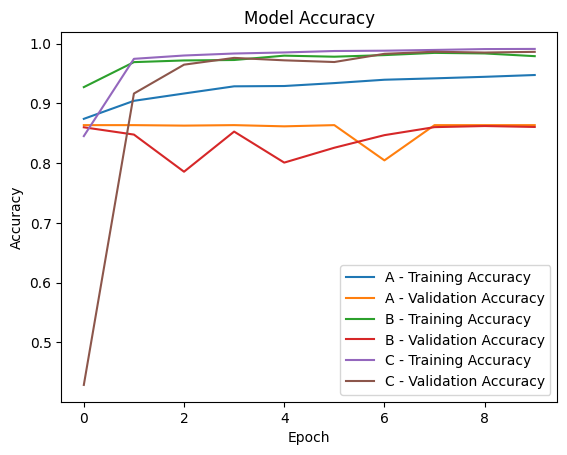

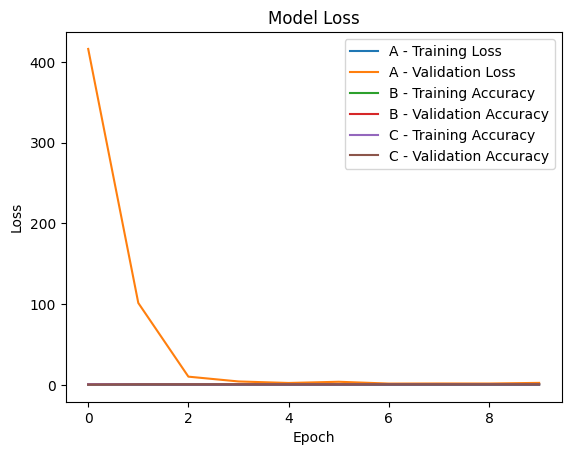

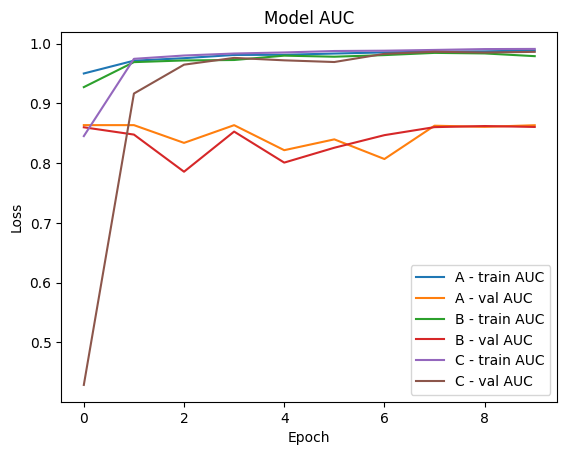

In [19]:
# Basic test results
from keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

# Accuracy,Loss Graph
plt.plot(ModelA['accuracy'], label='A - Training Accuracy')
plt.plot(ModelA['val_accuracy'], label='A - Validation Accuracy')
plt.plot(ModelB['accuracy'], label='B - Training Accuracy')
plt.plot(ModelB['val_accuracy'], label='B - Validation Accuracy')
plt.plot(ModelC['accuracy'], label='C - Training Accuracy')
plt.plot(ModelC['val_accuracy'], label='C - Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(ModelA['loss'], label='A - Training Loss')
plt.plot(ModelA['val_loss'], label='A - Validation Loss')
plt.plot(ModelB['accuracy'], label='B - Training Accuracy')
plt.plot(ModelB['val_accuracy'], label='B - Validation Accuracy')
plt.plot(ModelC['accuracy'], label='C - Training Accuracy')
plt.plot(ModelC['val_accuracy'], label='C - Validation Accuracy')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(ModelA['auc'], label='A - train AUC')
plt.plot(ModelA['val_auc'], label='A - val AUC')
plt.plot(ModelB['accuracy'], label='B - train AUC')
plt.plot(ModelB['val_accuracy'], label='B - val AUC')
plt.plot(ModelC['accuracy'], label='C - train AUC')
plt.plot(ModelC['val_accuracy'], label='C - val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [170]:
#K-fold-cross validation
from sklearn.model_selection import KFold
import tensorflow as tf
model = tf.keras.models.load_model('Models/MobileNetV3Large-UNet(5e-4)(16).keras')
acc_per_fold = []
loss_per_fold = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
i = 1
for train, test in kfold.split(X_test, y_test):
    print(f'Kfold {i}')
    scores = model.evaluate(X_test[test], y_test[test], verbose=0)
    print(f'Score for fold {i}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    i = i + 1

Kfold 1
Score for fold 1: loss of 0.12064458429813385; accuracy of 98.20541739463806%
Kfold 2
Score for fold 2: loss of 0.1222139373421669; accuracy of 98.17646741867065%
Kfold 3
Score for fold 3: loss of 0.1207776814699173; accuracy of 98.18214774131775%
Kfold 4
Score for fold 4: loss of 0.1313200294971466; accuracy of 97.62391448020935%
Kfold 5
Score for fold 5: loss of 0.11086247861385345; accuracy of 98.66141080856323%


In [177]:
#K-fold-cross validation
from sklearn.model_selection import KFold
import tensorflow as tf
model2 = tf.keras.models.load_model('Models/MobileNetV3Large-UNet(5e-4)(16)(F-20).keras')
acc_per_fold = []
loss_per_fold = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
i = 1
for train, test in kfold.split(X_test, y_test):
    print(f'Kfold {i}')
    scores = model2.evaluate(X_test[test], y_test[test], verbose=0)
    print(f'Score for fold {i}: {model2.metrics_names[0]} of {scores[0]}; {model2.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    i = i + 1

Kfold 1
Score for fold 1: loss of 0.05682368203997612; accuracy of 98.44856262207031%
Kfold 2
Score for fold 2: loss of 0.05795983597636223; accuracy of 98.40068221092224%
Kfold 3
Score for fold 3: loss of 0.05659271031618118; accuracy of 98.48284125328064%
Kfold 4
Score for fold 4: loss of 0.06470075249671936; accuracy of 98.15927743911743%
Kfold 5
Score for fold 5: loss of 0.04882539436221123; accuracy of 98.76723885536194%


In [178]:
model.evaluate(X_test, y_test)
model2.evaluate(X_test, y_test)


7/7 [==============================] - 1s 139ms/step - loss: 0.0570 - accuracy: 0.9845 - recall_8: 0.9848 - precision_8: 0.9843 - auc_8: 0.9980


[0.05698040500283241,
 0.9845172166824341,
 0.9847579598426819,
 0.9842544198036194,
 0.9980024695396423]

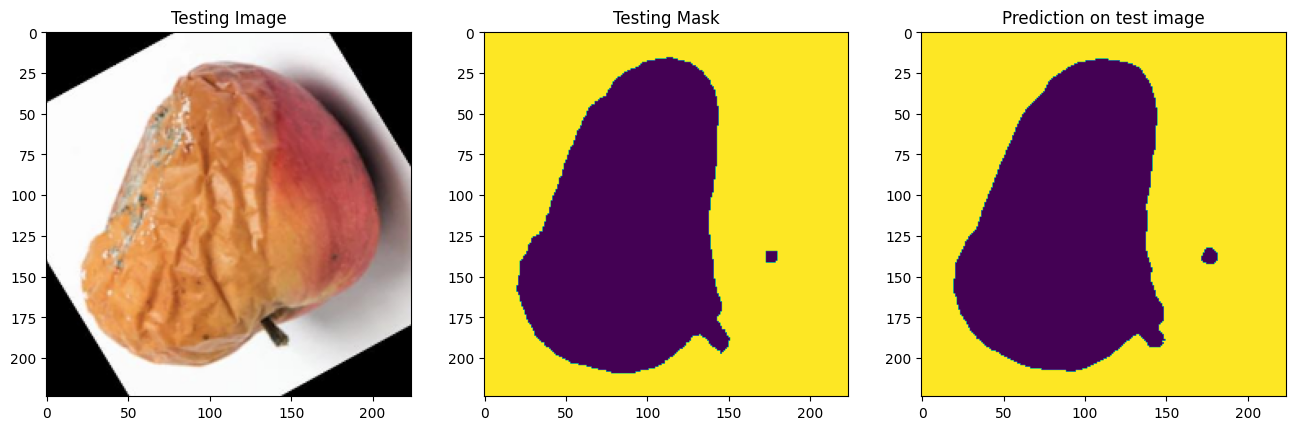

In [144]:
# randomly selecting an image from the test set and making prediction...
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(16, 12))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(132)
plt.title('Testing Mask')
plt.imshow(ground_truth)
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

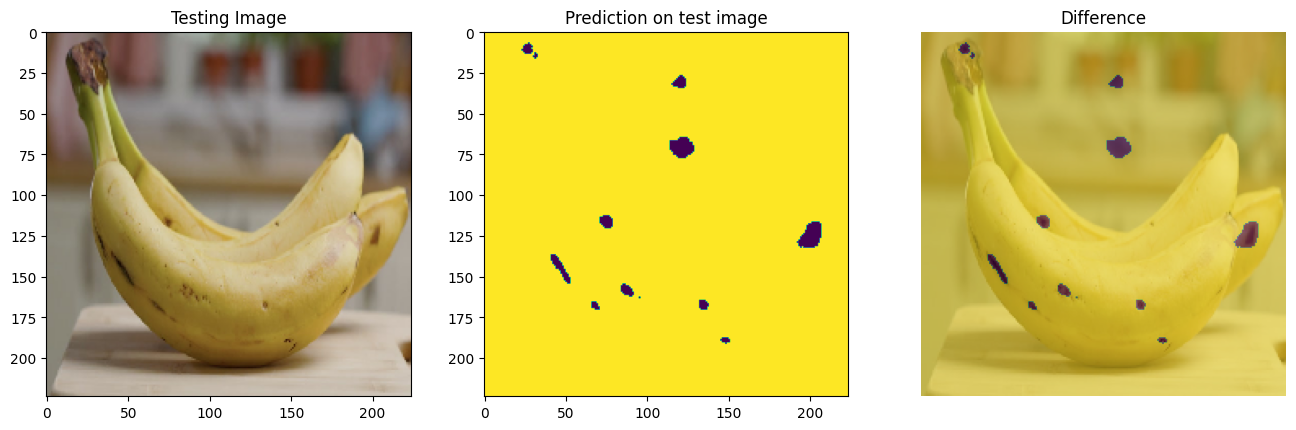

In [145]:
#Custom Image , Generalization test
import matplotlib.image as mpimg
img_file = "D:/TensorflowTrain/custom/ta79q50c-720.jpg"
#img_file = "C:/Users/wwwlo/labelme/examples/instance_segmentation/train/spoiled2/"
img = tf.keras.preprocessing.image.load_img(img_file, target_size=(224, 224))
test_img_input=np.expand_dims(img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
def show_diff(image, mask, a, b):
    plt.figure(figsize=(a, b))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(232)
    plt.title('Prediction on test image')
    plt.imshow(mask)
    plt.subplot(233)
    plt.imshow(image)
    plt.title('Difference')
    plt.imshow(np.squeeze(mask), alpha=0.5)
    plt.axis("off")

show_diff(img, predicted_img, 16, 12)

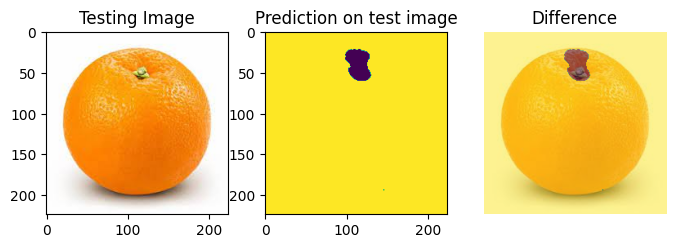

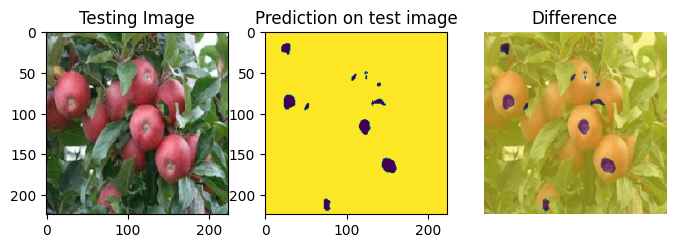

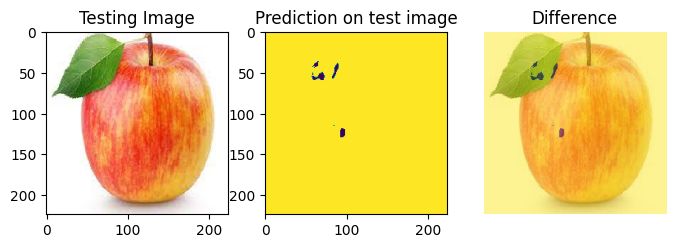

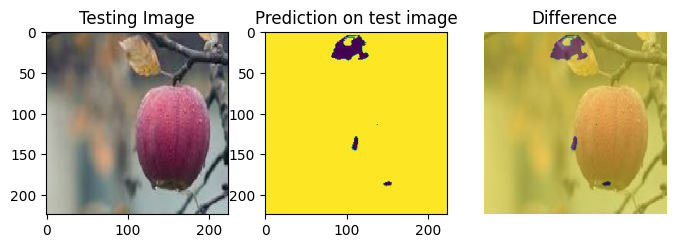

In [147]:
#List n row
images=[]
custom_path="D:/TensorflowTrain/custom/" #path to original images
def show_diff_n(images, n, custom_path, a, b):
    for im in os.listdir(custom_path):   
        images.append(os.path.join(custom_path,im))
    for i in range(n):
        number = random.randint(0, len(images)-1)
        img = tf.keras.preprocessing.image.load_img(images[number], target_size=(224, 224))
        test_img_input=np.expand_dims(img, 0)
        prediction = (model.predict(test_img_input))
        predicted_img=np.argmax(prediction, axis=3)[0,:,:]
        show_diff(img, predicted_img, a, b)
    
show_diff_n(images,4,custom_path, 8, 12)


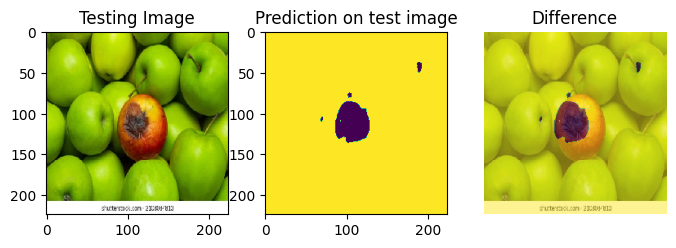

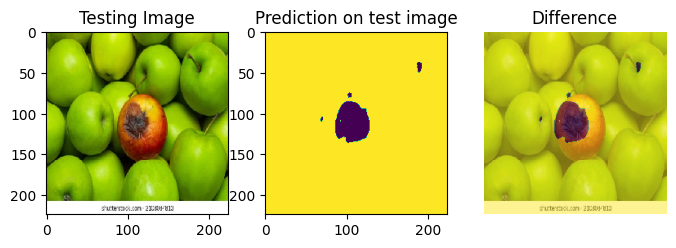

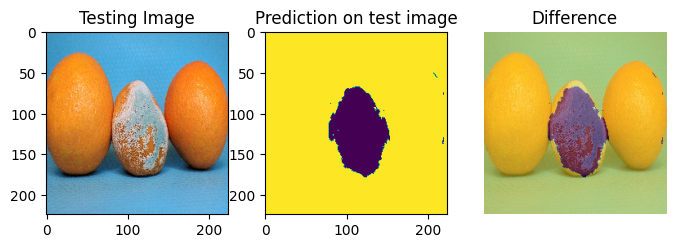

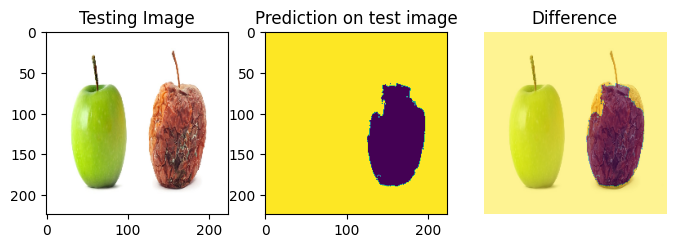

In [158]:
#List n row
images=[]
custom_path="D:/TensorflowTrain/custom2/" #path to original images
def show_diff_n(images, n, custom_path, a, b):
    for im in os.listdir(custom_path):   
        images.append(os.path.join(custom_path,im))
    for i in range(n):
        number = random.randint(0, len(images)-1)
        img = tf.keras.preprocessing.image.load_img(images[number], target_size=(224, 224))
        test_img_input=np.expand_dims(img, 0)
        prediction = (model.predict(test_img_input))
        predicted_img=np.argmax(prediction, axis=3)[0,:,:]
        show_diff(img, predicted_img, a, b)
    
show_diff_n(images,4,custom_path, 8, 12)


In [3]:
model = keras.models.load_model('./Models/MobileNetV3Large-UNet(Final).keras')


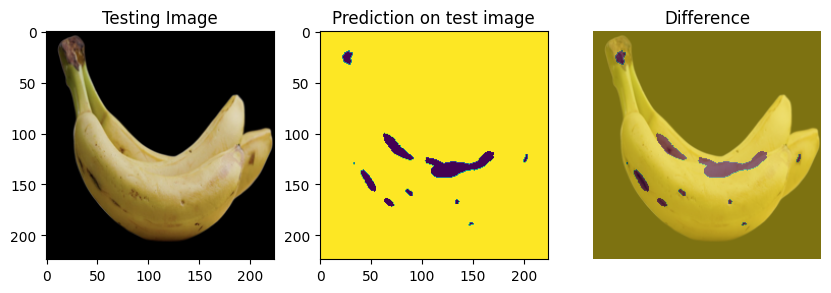

In [26]:
#Use rembg to remove background and test
import cv2
from rembg import remove 
from PIL import Image 
# Load the image with the fruit and background
img = Image.open("D:/TensorflowTrain/custom/ta79q50c-720.jpg")
img = img.resize((224, 224)) 
img = np.array(img) 
img = remove(img)
img = Image.fromarray(img).convert('RGB')
test_img_input=np.expand_dims(img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
show_diff(img, predicted_img, 10, 12)

